<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dacon-9회-펀다-상점매출-예측-모델링-경진대회" data-toc-modified-id="Dacon-9회-펀다-상점매출-예측-모델링-경진대회-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dacon 9회 펀다 상점매출 예측 모델링 경진대회</a></span></li><li><span><a href="#라이브러리-및-데이터" data-toc-modified-id="라이브러리-및-데이터-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>라이브러리 및 데이터</a></span></li><li><span><a href="#데이터-전처리" data-toc-modified-id="데이터-전처리-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리</a></span></li><li><span><a href="#탐색적-자료분석" data-toc-modified-id="탐색적-자료분석-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>탐색적 자료분석</a></span></li><li><span><a href="#변수-선택-및-모델-구축" data-toc-modified-id="변수-선택-및-모델-구축-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>변수 선택 및 모델 구축</a></span></li><li><span><a href="#모델-학습-및-검증" data-toc-modified-id="모델-학습-및-검증-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>모델 학습 및 검증</a></span><ul class="toc-item"><li><span><a href="#Backward-elimination" data-toc-modified-id="Backward-elimination-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Backward elimination</a></span></li></ul></li><li><span><a href="#TEST-RESULT" data-toc-modified-id="TEST-RESULT-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>TEST RESULT</a></span></li><li><span><a href="#결과-및-결언" data-toc-modified-id="결과-및-결언-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>결과 및 결언</a></span></li></ul></div>

# Dacon 9회 펀다 상점매출 예측 모델링 경진대회
**이동환**
**2019년 09월 07일**

# 라이브러리 및 데이터
**Library & Data**

In [1]:
###데이터 처리
import pandas as pd # 데이터 분석 version : 0.23.4
import numpy as np # 행렬 연산, version: 1.14.2
import datetime # 시간처리 , default function

###시각화
import matplotlib.pyplot as plt # 시각화 version 3.0.2 
import seaborn as sns # 시각화 version 0.9.0

###모델링
from sklearn.ensemble import RandomForestRegressor # 모델링 version : 0.20.1

###사용자 정의 함수
import interpolation

### waring 메세지 숨기기
import warnings
warnings.filterwarnings('ignore')

In [2]:
#사용한 데이터 불러오기
data_raw = pd.read_csv('../../DATA/funda_train.csv')
ju=pd.read_csv('memorial.csv',header=None)
temp=pd.read_csv('focast_temp.csv')
rain=pd.read_csv('focast_rain.csv')

# 데이터 전처리
**Data Cleansing & Pre-Processing**

In [3]:
## 전처리를 쉽게 하기 위한 (가)변수 추가 
data_raw['action']=1 # 매 결재를 1로 취급하여 일별/ 월별 결재횟수 카운트 
data_raw['year_month']=[i[:7] for i in data_raw.transacted_date] # 년월 변수로 년-월별 매출을 group sum 계산 

## 전처리 편의를 위해 np.na를 문자 'Nan'로 변경
data_raw["type_of_business"].fillna("Nan", inplace = True)
data_raw["region"].fillna("Nan", inplace = True)

In [4]:
# 스토어별로 년-월별 매출 합 계산
main_data_buff=data_raw[['year_month','store_id','amount']].groupby(['store_id','year_month']).sum() 

In [5]:
# 매출이 없는 달에 0값 삽입
# 최초 매출이 발생하기 전 시점도 동일하게 0으로 취급
main_data_buff.reset_index(level=[0,1], inplace=True)
main_data_buff=interpolation.interpolation(main_data_buff, method='zero') #r
main_data=main_data_buff

In [6]:
# year_month_id 추가 
ymi=np.concatenate((np.unique(main_data['year_month'].values).reshape(-1,1),np.arange(33).reshape(-1,1)),axis=1)
ymi=pd.DataFrame(ymi,columns=['year_month','year_month_id'])
main_data=pd.merge(main_data,ymi,how='left', on = ['year_month'])


In [7]:
## 각 transacted_date에 해당하는 요일 삽입
uniq_da = np.unique(data_raw['transacted_date'].values)
weekday_list=[]
for i in range(len(uniq_da)):
    y,m,d=uniq_da[i].split('-')
    d = datetime.date(int(y), int(m), int(d))  # 년월일 - > 요일 월 - 일 ( 0 - 6 )
    weekday_list.append(d.weekday())

var_week=np.concatenate((uniq_da.reshape(-1,1),np.array(weekday_list).reshape(-1,1)),axis=1 )
var_week=pd.DataFrame(var_week,columns=['transacted_date','weekday'])

## 공휴일 추가 
ju.columns=['transacted_date','memo','week']
ju=ju[ju.week==' 주']

memo_day=[str(i)[:4]+'-'+str(i)[4:6]+'-'+str(i)[6:] for i in list(ju.transacted_date.values)]
idx=var_week[np.isin(var_week.transacted_date.values, np.array(memo_day))].index.values
var_week.iloc[idx,1]=6  # 토요일 5 일요일 6 휴일 6  

### 근무일과 / 휴일로 구분짓기 
var_week['holiday']=0
var_week.holiday.values[np.isin(var_week.weekday.values,np.array([5,6]))]=1
var_week['year_month']=[i[:7] for i in var_week.transacted_date]

### 각 year-month에 해당하는 휴일 수 구하기
var_week01=var_week[['year_month','holiday']].groupby(['year_month']).sum()
var_week01.reset_index(level=0, inplace=True)

main_data=pd.merge(main_data,var_week01,how='left', on = ['year_month'])


In [8]:
## 계절성분 추가 
## 기온과 강수는 10년 평균을 사용하였으며 이는 앞으로 예측할 시점의 시간을 모르기 때문에 기온/강수의 경향만 데이터에 추가함 
## month 추가 
main_data['month']=[i[-2:]for i in main_data.year_month]


In [9]:
## 월별 평균 기온
temp.columns=['year_month','loc','mean_temp','min_tmp','max_tmp']

month = [datetime.datetime.strptime(i,'%y-%b').strftime('%Y-%m')[-2:] for i in temp.year_month ]
temp['month'] = month

temp=temp[['month','mean_temp']].groupby(['month']).mean()
temp.reset_index(level=0, inplace=True)
#temp.drop(['year_month'],axis=1)

main_data=pd.merge(main_data,temp,how='left', on = ['month'])


In [10]:
## 월별 강수량 추가
rain.columns=['year_month','loc','rain']

month = [datetime.datetime.strptime(i,'%y-%b').strftime('%Y-%m')[-2:] for i in rain.year_month ]
rain['month'] = month

rain=rain[['month','rain']].groupby(['month']).mean()
rain.reset_index(level=0, inplace=True)

main_data=pd.merge(main_data,rain,how='left', on = ['month'])

In [11]:
##############################################
#### 01 normalization by store_id
##############################################
store_list=np.unique(main_data.store_id.values)
st_len=store_list.shape[0]

##Normalization
main_data['amount01']= 0
main_data['min_amount']= 0
main_data['max_amount']= 0

store_id_list = np.unique(main_data.store_id.values)

for i in range(len(store_id_list)):

    store_id=store_id_list[i]
    sub_id=main_data[main_data.store_id == store_id]
    
    _min=sub_id.intr_amount.min()
    _max=sub_id.iloc[:,:].intr_amount.max() # -3
    
    sub01=((sub_id.intr_amount-_min)/(_max-_min))*1
    
    main_data.iloc[ 33*i : 33*(i+1),main_data.columns.get_loc("amount01")]=sub01
    main_data.iloc[ 33*i : 33*(i+1),main_data.columns.get_loc("min_amount")]=_min
    main_data.iloc[ 33*i : 33*(i+1),main_data.columns.get_loc("max_amount")]=_max
    

# 탐색적 자료분석
**Exploratory Data Analysis**

{'whiskers': [<matplotlib.lines.Line2D at 0x1553db205f8>,
 'caps': [<matplotlib.lines.Line2D at 0x1553db20c88>,
 'boxes': [<matplotlib.lines.Line2D at 0x1553db20198>],
 'medians': [<matplotlib.lines.Line2D at 0x1553db34358>],
 'fliers': [<matplotlib.lines.Line2D at 0x1553db346a0>],
 'means': []}

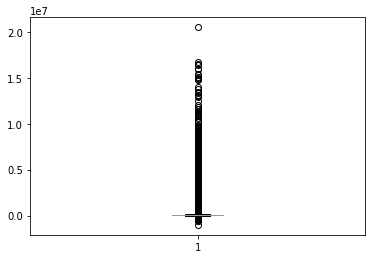

In [12]:
###########################
##### 탐색 : 스토어별-일별 매출 boxplot 
###########################
store_date_amout=data_raw[['store_id','transacted_date','amount']].groupby(['store_id','transacted_date']).sum()
store_date_amout.reset_index(level=[0,1], inplace=True)
plt.boxplot(store_date_amout['amount'].values)
# 중심에 비하여 비교적 큰 값들이 존재하지만, 
#예측해야 하는 금액이라는 데이터 특성상 제거하지 않고 full data 사용

In [13]:
###########################
##### 탐색 : 일별 매장의 평균 매출
###########################
store_date_amout=data_raw[['store_id','transacted_date','amount']].groupby(['store_id','transacted_date']).sum()
store_date_amout.reset_index(level=[0,1], inplace=True)

In [14]:
tmp_tranbydat=store_date_amout[['store_id','transacted_date']].groupby(['transacted_date']).count()
tmp_tranbydat.reset_index(level=0, inplace=True)
tmp_tranbydat.columns = ['transacted_date','store_count']
_tmp=store_date_amout[['transacted_date','amount']].groupby(['transacted_date']).sum()
_tmp.reset_index(level=0, inplace=True)

In [15]:
_tmp=pd.merge(_tmp,tmp_tranbydat, how ='left' , on ='transacted_date' )
_tmp['amount_by_store'] = _tmp['amount'] / _tmp['store_count']

([<matplotlib.axis.XTick at 0x1553dd79240>,
 <a list of 13 Text xticklabel objects>)

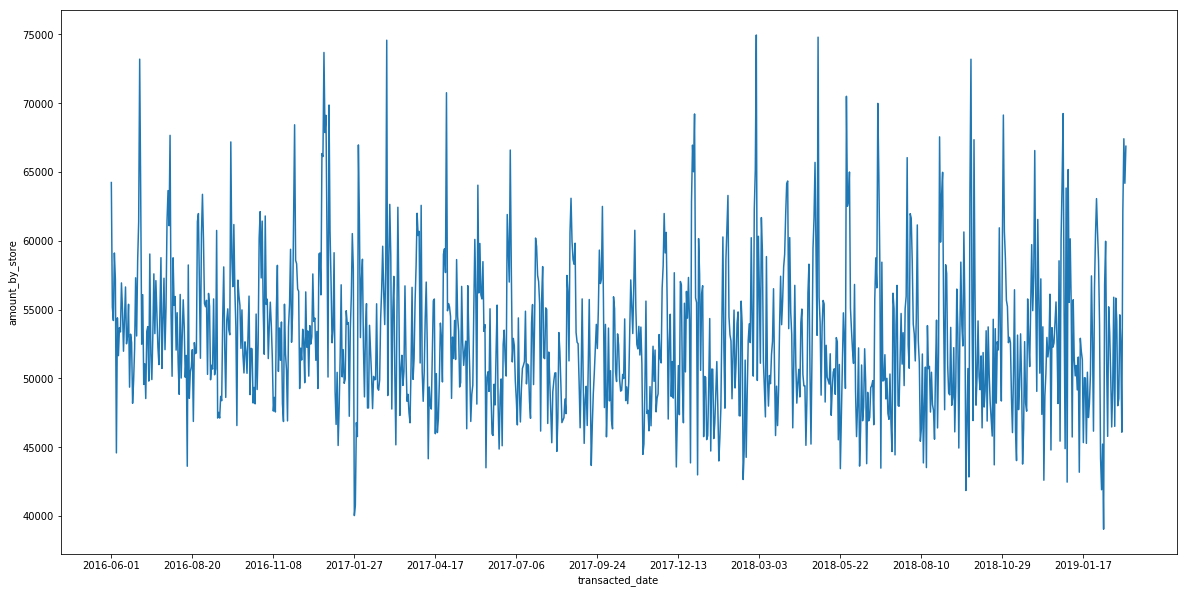

In [16]:
fig=plt.figure(figsize=(20,10))
plot_=sns.lineplot(_tmp['transacted_date'],_tmp['amount_by_store'])
fig.canvas.draw()
new_ticks = [i.get_text() for i in plot_.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 80), new_ticks[::80])

## 시간에 따른 트렌드가 있음을 확인할 수 있음 

Text(0, 0.5, 't2')

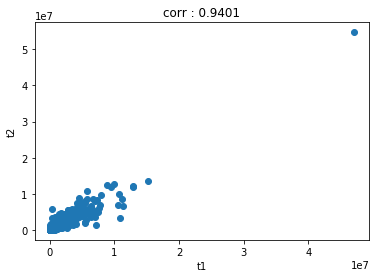

In [17]:
#########
### t시점과 t-n 시점과의 관계를 scatter polot을 통하여 살핌
#########

t1=main_data[main_data['year_month'].values == '2018-11']
t2=main_data[main_data['year_month'].values == '2018-10']
corr=np.corrcoef(t1.intr_amount.values,t2.intr_amount.values)[0][1] 
plt.scatter(t1.intr_amount.values,t2.intr_amount.values)
plt.title('corr : {}'.format(round(corr,4)))
plt.xlabel('t1')
plt.ylabel('t2')

Text(0, 0.5, 't2')

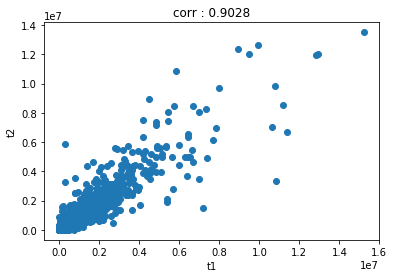

In [18]:
# 이상치 제거하여 상관관계 구하기
vis_data=main_data
vis_data=vis_data[vis_data.store_id.values != 538]

t1=vis_data[vis_data['year_month'].values == '2018-11']
t2=vis_data[vis_data['year_month'].values == '2018-10']

corr=np.corrcoef(t1.intr_amount.values,t2.intr_amount.values)[0][1] 
plt.scatter(t1.intr_amount.values,t2.intr_amount.values)
plt.title('corr : {}'.format(round(corr,4)))
plt.xlabel('t1')
plt.ylabel('t2')


In [19]:
ym=np.unique(vis_data.year_month.values)

In [20]:
corr_arr = np.zeros((len(ym),len(ym)))
corr_arr = pd.DataFrame(corr_arr,columns=ym, index=ym)

In [21]:
for i in ym:
    for j in ym:
        t1=vis_data[vis_data['year_month'].values == i]
        t2=vis_data[vis_data['year_month'].values == j]
        corr=np.corrcoef(t1.intr_amount.values,t2.intr_amount.values)[0][1] 
        
        corr_arr.loc[i,j]=round(corr,3)
        

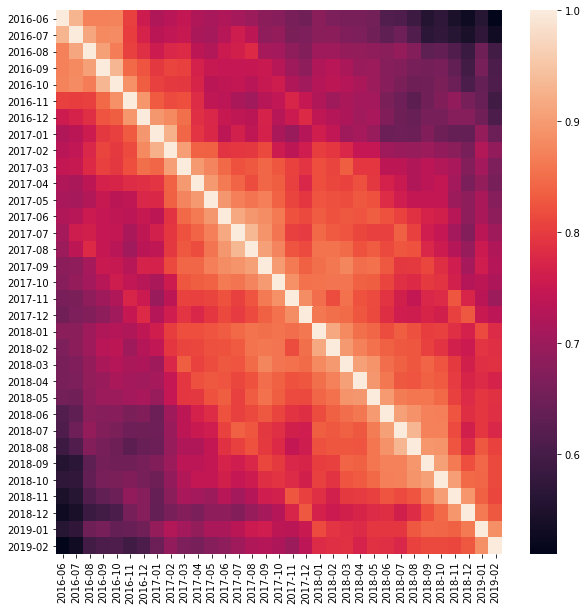

In [22]:
### year_month 간의 상관관계 히트맵
### 시점과 시점이 가까울수록 상관관계가 높음을 알 수 있음 
plt.figure(figsize=(10,10))
sns.heatmap(corr_arr)

{'whiskers': [<matplotlib.lines.Line2D at 0x15555038d68>,
 'caps': [<matplotlib.lines.Line2D at 0x15554db5438>,
 'boxes': [<matplotlib.lines.Line2D at 0x15555038940>],
 'medians': [<matplotlib.lines.Line2D at 0x15554db5ac8>],
 'fliers': [<matplotlib.lines.Line2D at 0x15554db5e10>],
 'means': []}

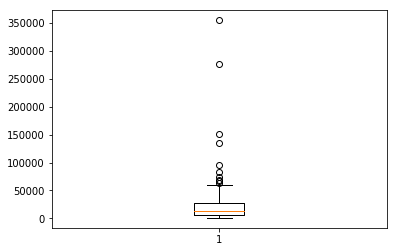

In [23]:
#업종별로 평균 결재액이 차이가 있는 업종이 있음  

_business01=data_raw[['type_of_business','amount']].groupby('type_of_business').mean()
plt.boxplot(_business01['amount'])

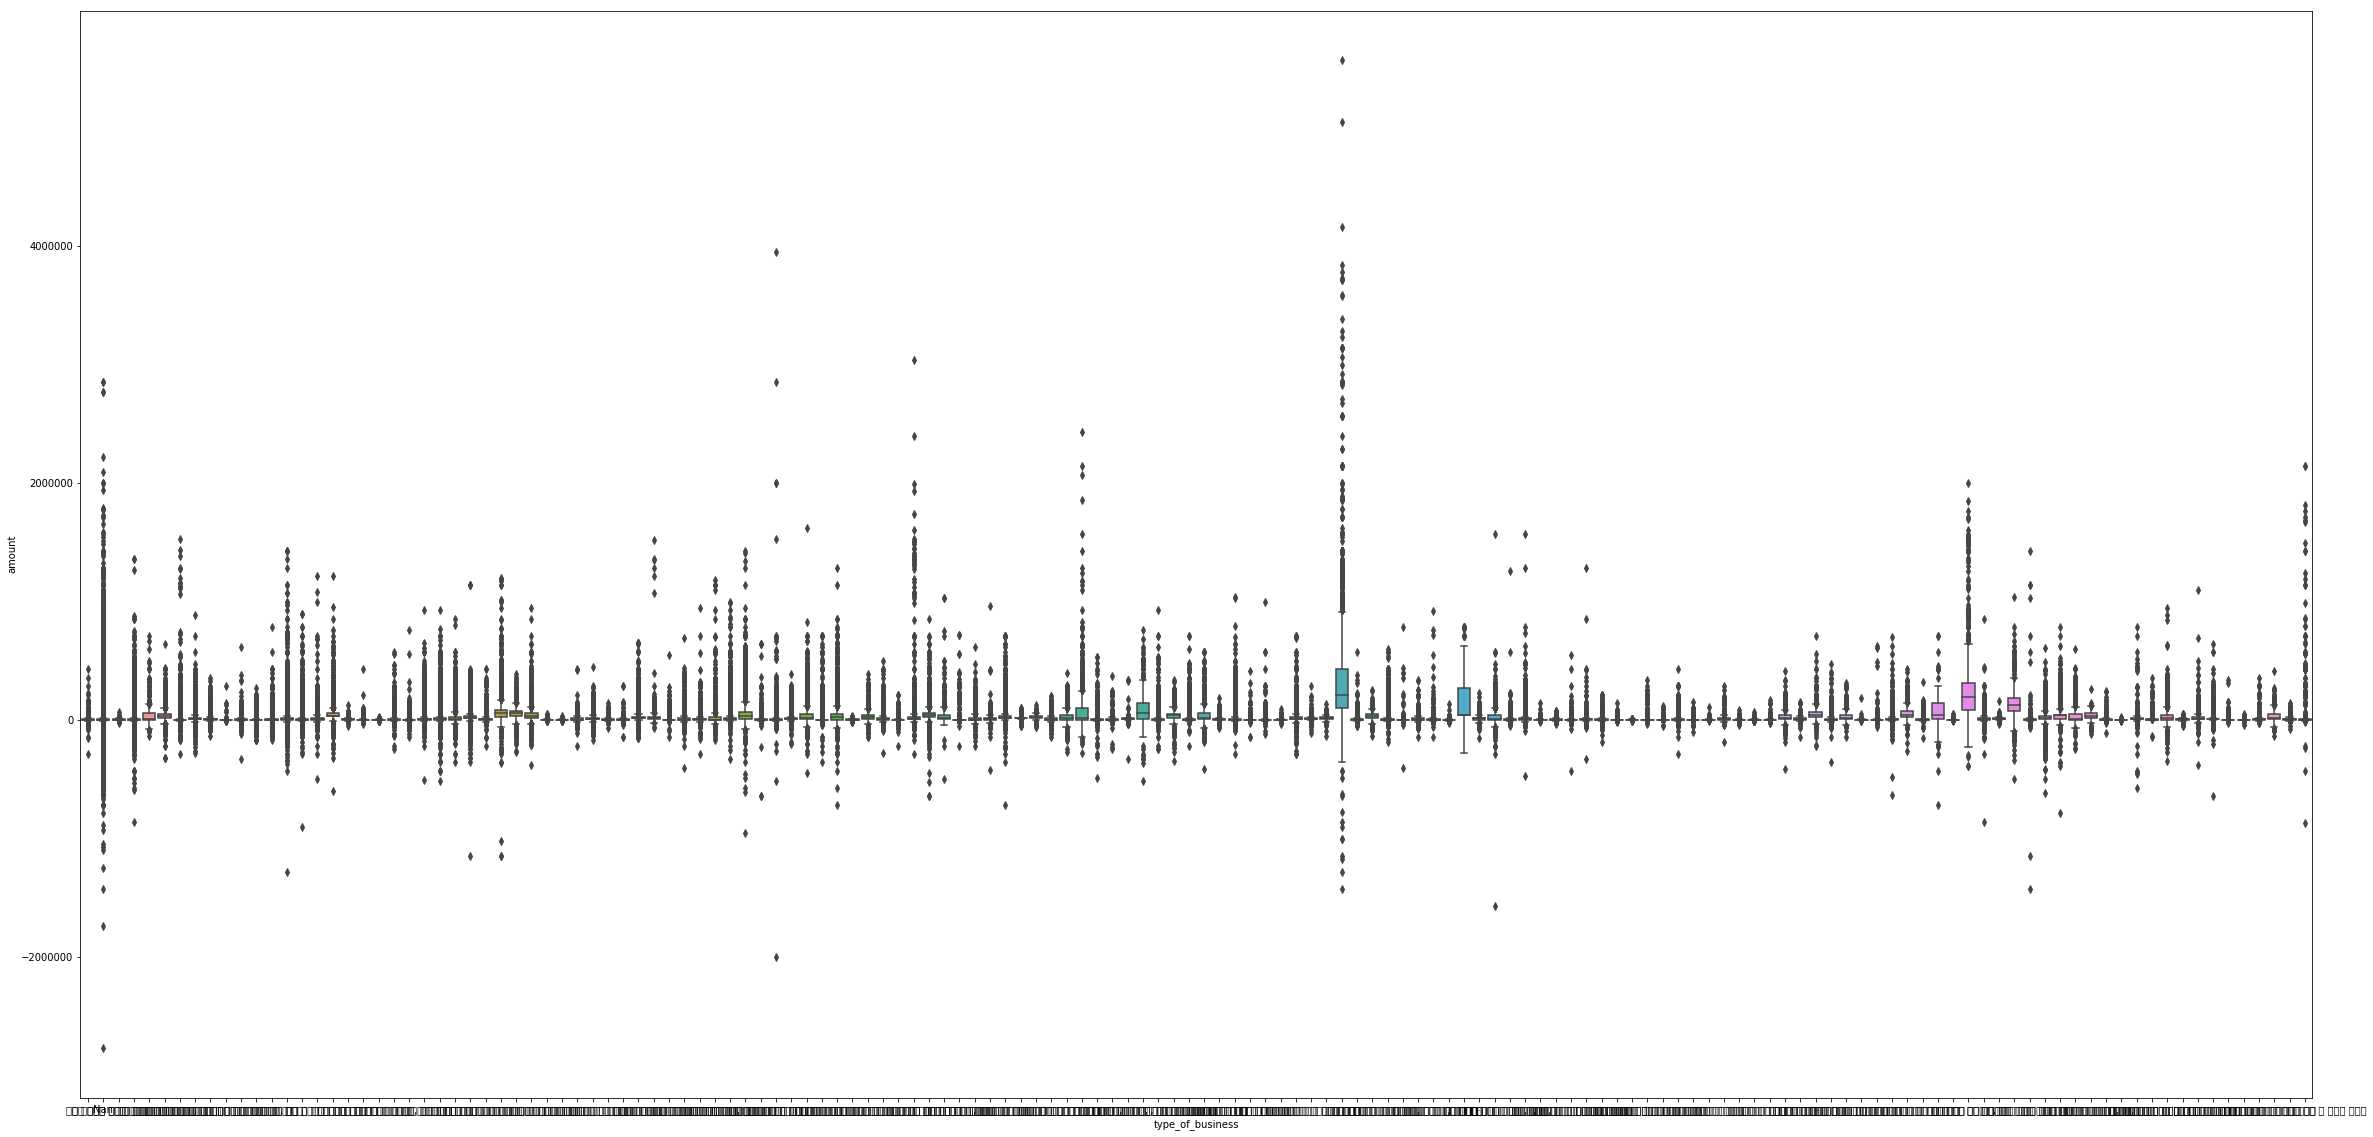

In [24]:
#업종에 따라서 결재액의 분포가 차이가 있는 업종이 있음 
_business02=data_raw[['type_of_business','amount']]

plt.figure(figsize=(40,20))
ax=sns.boxplot(x="type_of_business",y="amount", data=_business02)

{'whiskers': [<matplotlib.lines.Line2D at 0x1555538aac8>,
 'caps': [<matplotlib.lines.Line2D at 0x1555538aef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1555538a6a0>],
 'medians': [<matplotlib.lines.Line2D at 0x15555390828>],
 'fliers': [<matplotlib.lines.Line2D at 0x15555390b70>],
 'means': []}

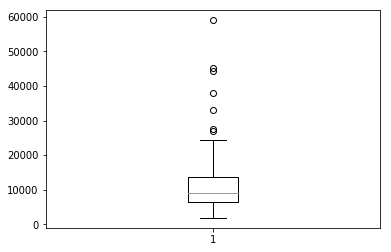

In [25]:
#지역별로 평균 결재액이 차이가 있는 업종이 있으며
#업종에 비하여 상대적으로 그 차이가 적음을 알 수 있음 
region=data_raw[['region','amount']].groupby('region').mean()
plt.boxplot(region['amount'])

([<matplotlib.axis.XTick at 0x155553b7470>,
 <a list of 3 Text xticklabel objects>)

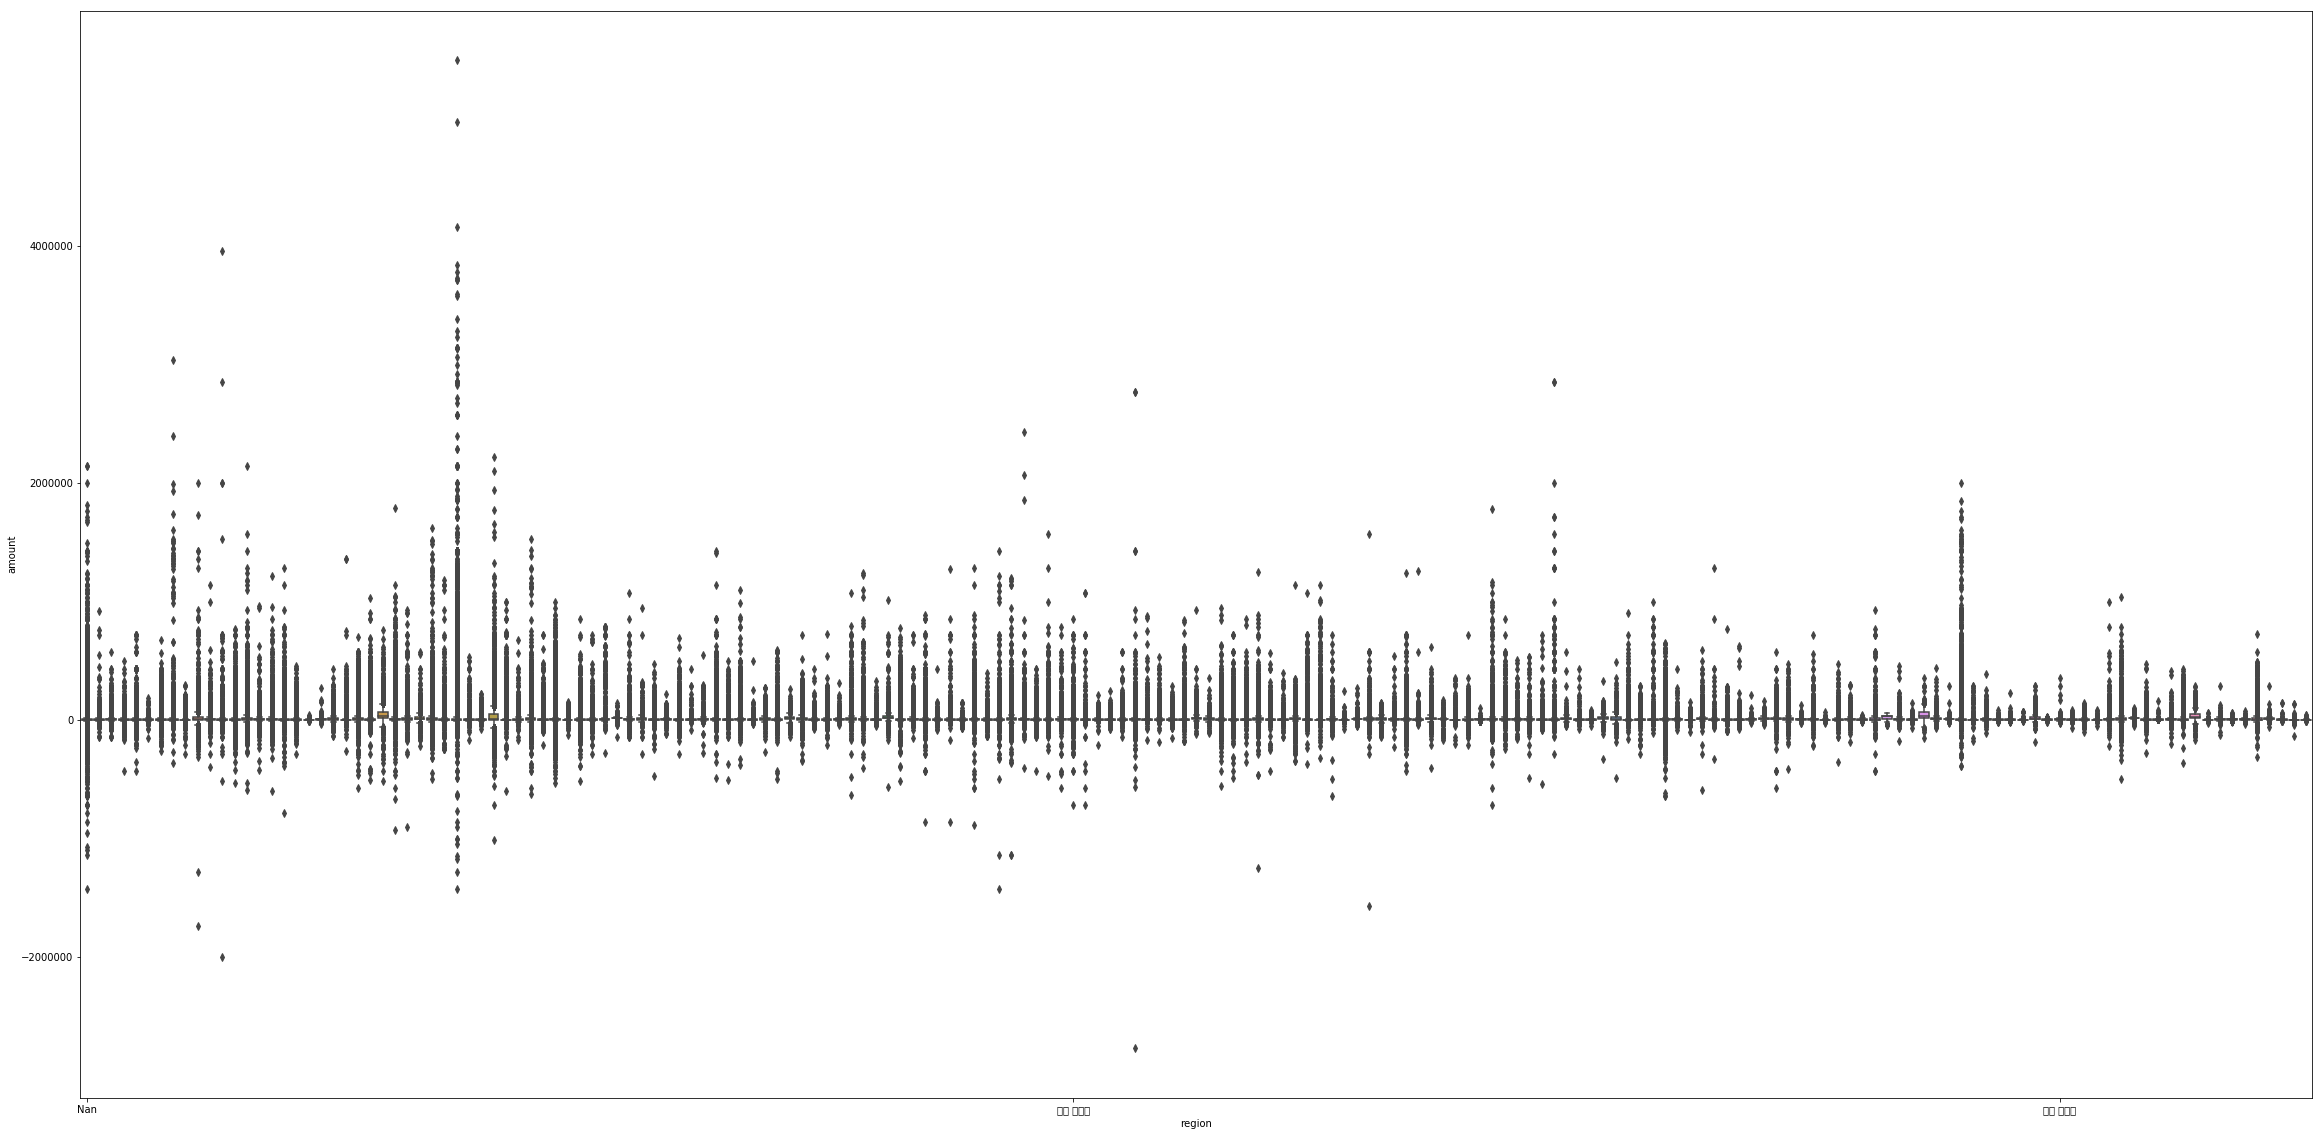

In [26]:
#지역에 따라서 결재액의 분포가 차이가 있는 지역이 있음 

_region02=data_raw[['region','amount']]

plt.figure(figsize=(40,20))
ax=sns.boxplot(x="region",y="amount", data=_region02)
fig.canvas.draw()
new_ticks = [i.get_text() for i in ax.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 80), new_ticks[::80])

# 변수 선택 및 모델 구축  
**Feature Engineering**

In [27]:
###########################
##### 변수추가 : store_id별 영업일수 대비 평균 매출
###########################

store_date_custom=data_raw[['store_id','transacted_date','action']].groupby(['store_id','transacted_date']).sum()
store_date_custom.reset_index(level=0, inplace=True)
store_date_custom.reset_index(level=0, inplace=True)

# 스토어별 영업일수
store_date_custom['open']=1
store_date_custom01=store_date_custom[['store_id','open']].groupby(['store_id']).count()
store_date_custom01.reset_index(level=0, inplace=True)

store_mean_amount=data_raw[['store_id','amount']].groupby(['store_id']).mean()
store_mean_amount.reset_index(level=0, inplace=True)
store_mean_amount

#스토어별 평균매출/영업일수
store_date_amount_ratio=pd.merge(store_mean_amount,store_date_custom01 , how = 'inner', on = 'store_id')
store_date_amount_ratio['amount_over_open_ratio'] = store_date_amount_ratio.amount.values / \
                                                store_date_amount_ratio.open.values 
#변수이름 추가
store_date_amount_ratio.columns = ['store_id', 'mean_amount', 'open', 'amount_over_open_ratio']
main_data=pd.merge(main_data,store_date_amount_ratio,how='left',on='store_id')


In [28]:
###########################
##### 변수추가 : store_id별 영업일수 대비 평균 결재 빈도
###########################
#data_raw['action']=1
store_date_custom=data_raw[['store_id','transacted_date','action']].groupby(['store_id','transacted_date']).sum()
store_date_custom.reset_index(level=0, inplace=True)
store_date_custom.reset_index(level=0, inplace=True)

# 스토어별 구매 빈도 
store_date_custom00=store_date_custom[['store_id','action']].groupby(['store_id']).sum()
store_date_custom00.reset_index(level=0, inplace=True)


# 스토어별 영업일수
store_date_custom['open']=1
store_date_custom01=store_date_custom[['store_id','open']].groupby(['store_id']).count()
store_date_custom01.reset_index(level=0, inplace=True)

#스토어별 구배빈도/영업일수
store_date_custom_freq_ratio=pd.merge(store_date_custom00,store_date_custom01, how ='inner', on ='store_id')
store_date_custom_freq_ratio['action_over_open_ratio'] = store_date_custom_freq_ratio.action.values/ \
                                                    store_date_custom_freq_ratio.open.values
#중복 제거 
store_date_custom_freq_ratio=store_date_custom_freq_ratio.drop(['open'],axis=1)

#변수이름 추가
store_date_custom_freq_ratio.columns =['store_id', 'action', 'action_over_open_ratio']
main_data[np.isnan(main_data.mean_amount.values)]
main_data=pd.merge(main_data,store_date_custom_freq_ratio,how='left',on='store_id')

In [29]:
###########################
##### 변수추가 : 지역 region 181개 지역
###########################

store_region=data_raw[['store_id','region']].drop_duplicates()
store_region=store_region.reset_index(drop=True)

uniq_reg=np.unique(store_region['region'].values).reshape(-1,1) # 지역별 아이디 만들기 
uniq_reg_id=np.concatenate((uniq_reg,np.arange(uniq_reg.shape[0]).reshape(-1,1)),axis=1)
uniq_reg_id=pd.DataFrame(uniq_reg_id,columns=['region','region_id'])


region_by_freq=data_raw[['region','action']].groupby('region').sum() # 지역별 결재 횟수 
region_by_freq.reset_index(level=0, inplace=True)
region_by_freq.columns=['region','region_by_action']


region_by_amount_sum=data_raw[['region','amount']].groupby('region').sum() # 지역별 총 결재 금액 
region_by_amount_sum.reset_index(level=0, inplace=True)
region_by_amount_sum.columns=['region','region_by_amount']


region_by=pd.merge(region_by_freq,region_by_amount_sum, how = 'inner', on = 'region' )
region_by['region_action_amount_ratio']=region_by.region_by_amount.values/region_by.region_by_action.values # 구매력 = 지역별 총 결재 금액/지역별 결재 횟수 

store_region=pd.merge(store_region,region_by,how='left',on='region')
store_region=pd.merge(store_region,uniq_reg_id,how='left',on='region' ) # 사업별 아이디 merge
store_region=store_region.drop(['region'],axis=1) # Char 제거

main_data=pd.merge(main_data,store_region,how='left',on='store_id')

In [30]:
###########################
##### 변수추가 : 업종 type_of_business 146개 업종
###########################

store_business=data_raw[['store_id','type_of_business']].drop_duplicates()
store_business=store_business.reset_index(drop=True)

uniq_bun=np.unique(store_business['type_of_business'].values).reshape(-1,1) # 사업별 아이디 만들기 
uniq_bun_id=np.concatenate((uniq_bun,np.arange(uniq_bun.shape[0]).reshape(-1,1)),axis=1)
uniq_bun_id=pd.DataFrame(uniq_bun_id,columns=['type_of_business','type_of_business_id'])

business_by_freq=data_raw[['type_of_business','action']].groupby('type_of_business').sum() # 사업별 결재 횟수
business_by_freq.reset_index(level=0, inplace=True)
business_by_freq.columns=['type_of_business','business_by_action']
#region_by_freq['region_by_freq_rank']=region_by_freq.action.rank()

business_by_amount_sum=data_raw[['type_of_business','amount']].groupby('type_of_business').sum() # 사업별 총 결재 금액 
business_by_amount_sum.reset_index(level=0, inplace=True)
business_by_amount_sum.columns=['type_of_business','business_by_amount']

business_by=pd.merge(business_by_freq,business_by_amount_sum, how = 'inner', on = 'type_of_business' )
business_by['business_action_amount_ratio']=business_by.business_by_amount.values/business_by.business_by_action.values#사업별 결재규모 = 사업별 결재 횟수/ 사업별 총 결재 금액 

store_business=pd.merge(store_business,business_by,how='left',on='type_of_business' )
store_business=pd.merge(store_business,uniq_bun_id,how='left',on='type_of_business' ) # 사업별 아이디 merge
store_business=store_business.drop(['type_of_business'],axis=1) # Char 제거

main_data=pd.merge(main_data,store_business,how='left',on='store_id')

In [31]:
data = main_data
data.columns # 생성된 Full 변수목록

Index(['year_month', 'store_id', 'intr_amount', 'nan', 'amount',
       'year_month_id', 'holiday', 'month', 'mean_temp', 'rain', 'amount01',
       'min_amount', 'max_amount', 'mean_amount', 'open',
       'amount_over_open_ratio', 'action', 'action_over_open_ratio',
       'region_by_action', 'region_by_amount', 'region_action_amount_ratio',
       'region_id', 'business_by_action', 'business_by_amount',
       'business_action_amount_ratio', 'type_of_business_id'],
      dtype='object')

**Initial Modeling**

In [32]:
#train _ test data validtaion
train_data=data[~np.isin(data.year_month.values,np.array(['2019-02','2019-01','2018-12']))]
valid_data=data[np.isin(data.year_month.values,np.array(['2019-02','2019-01','2018-12']))]
#train_data=train_data[train_data.nan !=True]
valid_data=valid_data[valid_data.nan !=True] # amount가 결측치인 행 제거 

In [33]:
# full model 
train_val = ['year_month_id','holiday', 'mean_temp', 'rain','mean_amount','amount_over_open_ratio','open','action','action_over_open_ratio',
       'region_by_action', 'region_by_amount', 'region_action_amount_ratio','business_by_action', 'business_by_amount',
       'business_action_amount_ratio']

In [34]:
train_X = train_data[train_val].values
train_Y = train_data[['intr_amount']].values # zero interpolation 한 amount

valid_X = valid_data[train_val].values
valid_Y = valid_data[['amount']].values

In [35]:
# Initial model for RandomForest model
# It is None paramater model that make it easy to bulid model 
rf = RandomForestRegressor(n_estimators=10,criterion='mse', random_state=777) # 과정중 MAE와 MSE의 차이는 크지 않았으며, 연산시간으로 MSE택
rf.fit(train_X, train_Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=777, verbose=0,
                      warm_start=False)

In [36]:
pred_Y=rf.predict(valid_X)

In [37]:
y_valid=valid_data[['store_id','amount']]
y_valid['pred'] = pred_Y
y_true_pred=y_valid.groupby('store_id').sum().values # 스토어별 12,1,2월 매출 합
np.mean(np.abs(y_true_pred[:,0] - y_true_pred[:,1])) # 스토어별 12,1,2월 매출 합의 잔차의 절대값의 평균

801528.5193406594

Text(0, 0.5, 'y_pred')

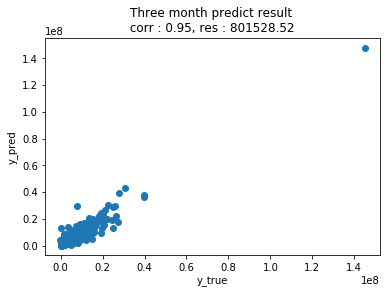

In [38]:
plt.scatter(y_true_pred[:,0],y_true_pred[:,1])
plt.title('Three month predict result \n corr : {}, res : {} '.format(round(np.corrcoef(y_true_pred[:,0],y_true_pred[:,1])[0][1],2),round(np.mean(np.abs(y_true_pred[:,0] - y_true_pred[:,1])),2)))
plt.xlabel('y_true')
plt.ylabel('y_pred')

In [39]:
# seq to seq LSTM moedel을 구성하여 이전 6개월의 자료로 이후 3개월의 매출을 예측하려고 했지만 
# 최적화하지 못한 관계로 최종모형에 사용하지 않았습니다.

# 빠른 모형수정, 높은 가독성의 이유로 keras를 사용하였습니다 
#from keras.models import Sequential
#from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed,Activation 
#from  getdata import data2rnn

#look_back=6
#train_X, train_Y = data2rnn(train_data,var_list,look_back=look_back,pred_k = 3) # t-n까지의 시점 데이터셋을 만들어주는 사용자 정의함수
#test_X, test_Y = data2rnn(test_data,var_list,look_back=look_back,pred_k = 3)    # t-n까지의 시점 데이터셋을 만들어주는 사용자 정의함수

#model = Sequential()  
#model.add(LSTM(128, input_shape=(look_back,len(var_list)), return_sequences=False))  
#model.add(RepeatVector(3))
#model.add(LSTM(128, return_sequences=True))  
#model.add(TimeDistributed(Dense(1)))
#model.add(Activation('sigmoid'))   
#model.compile(loss='mae', optimizer='adam') 

#train_Y=train_Y.reshape(-1, 3, 1)
#model.fit(train_X, train_Y, epochs=50, batch_size=128)
#pred_y=model.predict(train_X)

# 모델 학습 및 검증
**Model Tuning & Evaluation**

## Backward elimination

In [40]:
def backward_model_error(selected_var):
    '''
    변수를 한개 씩 제거하면서 모형의 error를 구하는 함수입니다.  
    '''
    error = []
    for i in range(len(selected_var)):
        train_val_sub= selected_var.copy()
        del train_val_sub[i]
        train_X = train_data[train_val_sub].values
        train_Y = train_data[['intr_amount']].values

        valid_X = valid_data[train_val_sub].values
        valid_Y = valid_data[['amount']].values

        rf = RandomForestRegressor(n_estimators=10,criterion='mse', random_state=777)
        rf.fit(train_X, train_Y)
        pred_Y=rf.predict(valid_X)

        y_valid=valid_data[['store_id','amount']]
        y_valid['pred'] = pred_Y      
        y_true_pred=y_valid.groupby('store_id').sum().values
        error.append(np.mean(np.abs(y_true_pred[:,0] - y_true_pred[:,1])))
    return error

In [41]:
train_val = ['year_month_id','holiday', 'mean_temp', 'rain','mean_amount','amount_over_open_ratio','open','action','action_over_open_ratio',
       'region_by_action', 'region_by_amount', 'region_action_amount_ratio','business_by_action', 'business_by_amount',
       'business_action_amount_ratio']

In [42]:
past_min_error = None
past_minimun_error_val_list = None
for i in range(len(train_val)):
    
    print('back ward step {}'.format(i+1))
    
    error = backward_model_error(train_val) # error 목록 
    min_error = np.min(np.array(error)) # 가장 작은 error
    
    print('min error : {}'.format(min_error))
    
    useless_var=np.argmin(np.array(error))
    del train_val[useless_var] # 해당 스텝에서 가장 작은 error인 variable 목록 

    print('optimal variable list at {} step : {}'.format(train_val, i+1))
    
    if past_min_error is None:
        past_min_error = min_error
        past_minimun_error_val_list = train_val
        
    elif past_min_error >= min_error:
        past_min_error = min_error
        past_minimun_error_val_list = train_val
        
    elif past_min_error < min_error:
        break        
        



back ward step 1
min error : 770858.0306080586
optimal variable list at ['year_month_id', 'mean_temp', 'rain', 'mean_amount', 'amount_over_open_ratio', 'open', 'action', 'action_over_open_ratio', 'region_by_action', 'region_by_amount', 'region_action_amount_ratio', 'business_by_action', 'business_by_amount', 'business_action_amount_ratio'] step : 1
back ward step 2
min error : 766305.3327912089
optimal variable list at ['year_month_id', 'mean_temp', 'rain', 'mean_amount', 'amount_over_open_ratio', 'open', 'action', 'action_over_open_ratio', 'region_by_action', 'region_by_amount', 'region_action_amount_ratio', 'business_by_amount', 'business_action_amount_ratio'] step : 2
back ward step 3
min error : 764731.1530989012
optimal variable list at ['year_month_id', 'rain', 'mean_amount', 'amount_over_open_ratio', 'open', 'action', 'action_over_open_ratio', 'region_by_action', 'region_by_amount', 'region_action_amount_ratio', 'business_by_amount', 'business_action_amount_ratio'] step : 3
back

In [43]:
past_minimun_error_val_list # 후진변수선택방법으로 validation data에서 가장 작은 error를 보이는 변수 목록 

['year_month_id',
 'rain',
 'mean_amount',
 'amount_over_open_ratio',
 'open',
 'action',
 'region_by_action',
 'region_action_amount_ratio',
 'business_by_amount',
 'business_action_amount_ratio']

In [44]:
train_X = train_data[past_minimun_error_val_list].values
train_Y = train_data[['intr_amount']].values

valid_X = valid_data[past_minimun_error_val_list].values
valid_Y = valid_data[['amount']].values

In [45]:
# Initial model for RandomForest model
# It is None paramater model that make it easy to bulid model 
rf = RandomForestRegressor(n_estimators=500,criterion='mse', random_state=777) # 과정중 MAE와 MSE의 차이는 크지 않았으며, 연산시간으로 MSE택
rf.fit(train_X, train_Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=777, verbose=0,
                      warm_start=False)

In [46]:
pred_Y=rf.predict(valid_X)
y_valid=valid_data[['store_id','amount']]
y_valid['pred'] = pred_Y
y_true_pred=y_valid.groupby('store_id').sum().values # 스토어별 12,1,2월 매출 합
np.mean(np.abs(y_true_pred[:,0] - y_true_pred[:,1])) # 스토어별 12,1,2월 매출 합의 잔차의 절대값의 평균

737097.968928498

Text(0, 0.5, 'y_pred')

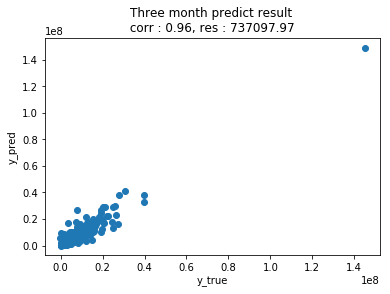

In [47]:
plt.scatter(y_true_pred[:,0],y_true_pred[:,1])
plt.title('Three month predict result \n corr : {}, res : {} '.format(round(np.corrcoef(y_true_pred[:,0],y_true_pred[:,1])[0][1],2),round(np.mean(np.abs(y_true_pred[:,0] - y_true_pred[:,1])),2)))
plt.xlabel('y_true')
plt.ylabel('y_pred')

# TEST RESULT

In [48]:
testdata_raw=pd.read_csv('submission_raw.csv')
testdata=testdata_raw

In [49]:
## 예측할 시점의 year_month 변수 만들기 
base = datetime.datetime(2019,3,1)
datelist = pd.date_range(base, periods=92).tolist()
date=[i.strftime("%Y-%m") for i in datelist]
date = np.unique(date)

date = pd.DataFrame(date)
date.columns = ['year_month']

In [50]:
## submission data와 합치기
date['idx']=1
testdata['idx']=1
testdata=pd.merge(date,testdata,how='left',on='idx').drop(['idx'],axis=1)

In [51]:
## 예측할 시점의 year_month_id 변수 만들기 
year_month=np.unique(testdata['year_month'])
year_month=np.concatenate((year_month.reshape(-1,1),(np.arange(year_month.shape[0])+33).reshape(-1,1)),axis=1)

year_month=pd.DataFrame(year_month,columns=['year_month','year_month_id'])
testdata=pd.merge(testdata,year_month,how='left', on = 'year_month')

In [52]:
## train set과 merge를 위하여 month 변수 추가 
testdata['month']=[int(i[-2:]) for i in testdata.year_month.values]

In [53]:
## merge 
test_val=past_minimun_error_val_list+['month','store_id']
test_val.remove('year_month_id')

data_test=data[test_val].drop_duplicates()
data_test=data_test.astype('float')

testdata=pd.merge(testdata, data_test, how='left', on=['month','store_id'])

In [54]:
testdata=testdata.sort_values(['store_id','year_month'])

In [55]:
## test_X 만들기
test_X=testdata[past_minimun_error_val_list]

In [56]:
## 최종모형 학습
train_XX=data[past_minimun_error_val_list].values
train_YY = data[['intr_amount']].values

rf = RandomForestRegressor(n_estimators=500, criterion='mse',random_state=777) 
rf.fit(train_XX, train_YY)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=777, verbose=0,
                      warm_start=False)

In [57]:
pred_Y = rf.predict(test_X)

In [58]:
y_test=testdata[['store_id']]
y_test['pred'] = pred_Y
y_pred_result=y_test.groupby('store_id').sum() # 스토어별 3,4,5월 매출 합

In [59]:
y_pred_result.to_csv('submission.csv',index=False)

# 결과 및 결언
**Conclusion & Discussion**

Market의 매출은 어느 요인에 영향을 받는지 알고싶은 단순 호기심에서 시작하였다.
위는 월별 하여 하였고 후 3개월을 예측하고자 하였다.

Randomforest는 비모수적인 방법으로 단순한 시도를 통해 풀고자 하는 문제의 다양한 특성을
비교적 쉽게 파악할 수 있는 장점이 있어서 초기 모형으로 사용하였다.

기존에 사용되는 랜덤포레스트 모형은 정의된 문제인 t+1 부터 t+3까지의 연속된 시점을 예측하는데는 적합한 방법은 아니며, 오버피팅의 문제가 있었다.
이 문제점을 수용하고자 시간성분을 변수로 분해하여(year_month_id, rain 등) response인 amount를 설명하고자 하였으며 
모형의 평가방법은 3개월 예측 결과인 valid_set의 결과로 평가하여 변수선택을 하였다.

Random Forest 모형의 
validation 결과는 738,222이었고
test 결과는 775,359.30554이었다.

최종적으로는 LSTM을 사용하여 seq to seq 기법으로 풀고자 하였으나 testset의 결과가 좋지 못하여 실패하였다.
train과 valid의 결과가 좋은데 반하여 test의 결과가 좋지 못한점을 미루어보아 
데이터 처리과정에서 훈련셋과 검증셋의 amount가 test data의 amount와 달려졌기 때문이라 추측하고 있다. 
차후 testset을 받을 기회가 된다면 이러한 문제가 왜 발생하였는지 파악하여 보다 더 나은 성능의 모형을 개발하고 싶다.